In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score,make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline

# стороняя библиотека для работы с несбалансированными датасетами
# pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN

# настройки отображения графиков
# %config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
%matplotlib inline

# увеличим  размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from tqdm import tqdm_notebook

# для воспроизводимости
r_state = 11

In [3]:
data_path = './data/creditcard.csv'

In [4]:
df = pd.read_csv(data_path)

https://beckernick.github.io/oversampling-modeling/

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


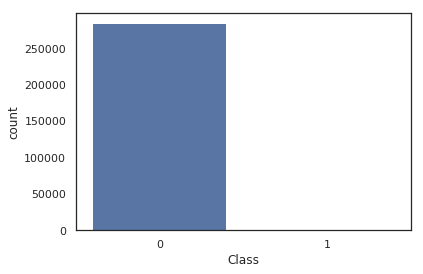

In [6]:
sns.countplot(df['Class']);

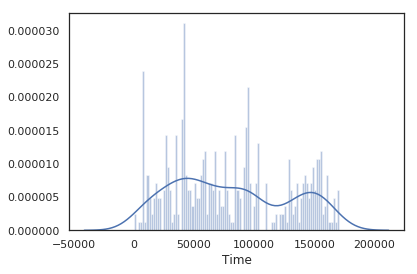

In [7]:
sns.distplot(df[df['Class']==1]['Time'],100);

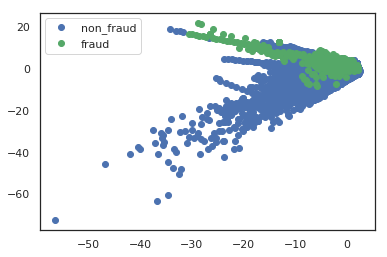

In [8]:
plt.plot(df[['V1','V2']].values[df['Class'] == 0,0], df[['V1','V2']].values[df['Class'] == 0, 1], 'bo', label='non_fraud')
plt.plot(df[['V1','V2']].values[df['Class'] == 1,0], df[['V1','V2']].values[df['Class'] == 1, 1], 'go', label='fraud')
plt.legend(loc=0);

## Оценивать модели будем на трех выборках. Сначала на тестовой выборке после SMOT, потом на на выборке, составленной из исходно, но сбалансированной и наконец, на исходной

In [9]:
# df = df.sample(n=100000,random_state = r_state)

In [10]:
def all_metrics_validation(clf,X,Y_true):
    print("Accuracy score: "+ str(accuracy_score(Y_true,clf.predict(X))))
    print("ROC AUC score: "+ str(roc_auc_score(Y_true,clf.predict_proba(X)[:,1]))) # нас интересуют положительные результаты
    print("Recall score: "+ str(recall_score(Y_true,clf.predict(X))))

In [11]:
def create_balanced_data_from_initial(data):
    fraud = data[(data['Class']==1)]
    not_fraud = data[(data['Class']==0)]
    new_df=pd.concat([fraud,data[:len(fraud)]])      
    X = new_df.drop(['Class','Time'], axis=1)
    Y = new_df['Class']
    return X,Y

### Для того, что получить сбалансированный датасет, я буду использовать алгоритм ADASYN(Adaptive Synthetic Sampling) . Поскольку SMOTE (Synthetic Minority Over-sampling Technique) создает больше примеров внутри кластера, а ADASYN создает больше синтетических примеров на границе. В таком случае, модели будут уверенно классифицировать транзакции внутри кластера, который уже был, поскольку будут лучше опознавать мошеннические транзакции на границе двух кластеров. Хотя это и может привести к ошибкам рода False Positive, мне кажется, что такой подход будет надежнее. Далее проведется сравнение двух этих алгоритмов

In [12]:
def create_balanced_data_smote(x,y):
    sm = SMOTE(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [13]:
def create_balanced_data_adasyn(x,y):
    sm = ADASYN(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [14]:
def estimate_model(clf, X_balanced, y_balanced, X_original,y_original, X_test_adasyn, y_test_adasyn):
    print('\nМетрики на оригинальном датасете: \n')
    all_metrics_validation(clf,X_original,y_original)
    print('\nМетрики на тестовой части ADASYN датасета:\n')
    all_metrics_validation(clf,X_test_adasyn, y_test_adasyn)
    print('\nМетрики на небольшой сбалансированой части из оригинального датасета:\n')
    all_metrics_validation(clf,X_balanced, y_balanced)
    

In [15]:
X_original = df.drop(['Class','Time'], axis=1)
y_original = df['Class']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3)

In [17]:
X_balanced, y_balanced = create_balanced_data_from_initial(df)

In [18]:
X_train_adasyn, y_train_adasyn = create_balanced_data_smote(X_train, y_train)

1    199009
0    199009
Name: Class, dtype: int64

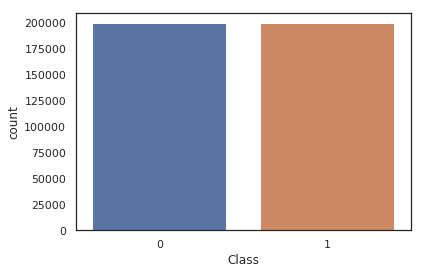

In [19]:
sns.countplot(y_train_adasyn['Class']);y_train_adasyn['Class'].value_counts()

In [20]:
X_test_adasyn, y_test_adasyn = create_balanced_data_smote(X_test, y_test)

# Случайный лес

In [21]:
%%time
parameters = {'max_features': ['auto'], 'min_samples_leaf': range(15,20,2),'max_depth': range(3,7,1),'n_estimators':range(10,50,10),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

rfc = RandomForestClassifier()

gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.8min finished


CPU times: user 32.2 s, sys: 277 ms, total: 32.5 s
Wall time: 3min 50s


In [22]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

({'max_depth': 6,
  'max_features': 'auto',
  'min_samples_leaf': 17,
  'n_estimators': 10,
  'n_jobs': -1},
 0.9383243973890628)

In [23]:
estimate_model(clf, X_balanced, y_balanced, X_original,y_original, X_test_adasyn, y_test_adasyn)


Метрики на оригинальном датасете: 

Accuracy score: 0.9966468520787761
ROC AUC score: 0.9869538988946331
Recall score: 0.9004065040650406

Метрики на тестовой части ADASYN датасета:

Accuracy score: 0.9518146437530771
ROC AUC score: 0.9895333358375498
Recall score: 0.9067826413147961

Метрики на небольшой сбалансированой части из оригинального датасета:

Accuracy score: 0.948170731707317
ROC AUC score: 0.9855967843215017
Recall score: 0.9004065040650406


# Метод ближайших соседей

In [24]:
%%time
parameters = {'n_neighbors': range(9,30,5),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

knn = KNeighborsClassifier()

gcv = GridSearchCV(knn, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  7.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.0min finished


CPU times: user 3.54 s, sys: 282 ms, total: 3.82 s
Wall time: 9min 2s


In [25]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

({'n_jobs': -1, 'n_neighbors': 9}, 0.9993919872970569)

In [26]:
estimate_model(clf, X_balanced, y_balanced, X_original,y_original, X_test_adasyn, y_test_adasyn)


Метрики на оригинальном датасете: 

Accuracy score: 0.9956461744268926
ROC AUC score: 0.9834202988812507
Recall score: 0.9654471544715447

Метрики на тестовой части ADASYN датасета:

Accuracy score: 0.9485147586336249
ROC AUC score: 0.9534667068650952
Recall score: 0.9021170843785901

Метрики на небольшой сбалансированой части из оригинального датасета:

Accuracy score: 0.9776422764227642
ROC AUC score: 0.9804824343975147
Recall score: 0.9654471544715447


# Логистическая регрессия

In [27]:
%%time
logit = LogisticRegression(n_jobs=-1)       

parameters = {'C': np.linspace(10,30,50),}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

gcv = GridSearchCV(logit, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

gcv.fit(X_train_adasyn, y_train_adasyn)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


CPU times: user 18.4 s, sys: 210 ms, total: 18.6 s
Wall time: 2min 27s


In [28]:
clf = gcv.best_estimator_
gcv.best_params_ , gcv.best_score_

({'C': 14.081632653061224}, 0.9396861448477205)

In [29]:
estimate_model(clf, X_balanced, y_balanced, X_original,y_original, X_test_adasyn, y_test_adasyn)


Метрики на оригинальном датасете: 

Accuracy score: 0.9824442517213411
ROC AUC score: 0.9820366494908815
Recall score: 0.9024390243902439

Метрики на тестовой части ADASYN датасета:

Accuracy score: 0.9587778116427919
ROC AUC score: 0.9875756813728007
Recall score: 0.9350573230487891

Метрики на небольшой сбалансированой части из оригинального датасета:

Accuracy score: 0.9441056910569106
ROC AUC score: 0.9743414964637451
Recall score: 0.9024390243902439
